# Дослідження впливу парникових газів на температуру

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR


# Завантаження та обробка данних

Дані про парникові гази за останні 800 000 років були зібрані з різних публічних баз даних, таких як National Oceanic and Atmospheric Administration. Будуть використані наступні дані:
- CO2 (ppm)
- N2O (ppb)
- СH4 (ppb)

Дані про температуру з 1750 року було взято з Lawrence Berkeley National DataBase.

## Парникові гази
### CO2

In [2]:
co2 = pd.read_csv('data/randomtree/co2-concentrations.csv', header = 7)

co2_new = co2.drop({'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'}, 1)
co2_new = co2_new.dropna()
co2_new[['Ice Core Measurements']] = co2_new[['Ice Core Measurements']].apply(pd.to_numeric)
co2_new = co2_new.rename({"Unnamed: 4": "quantity_co2"}, axis = 'columns')

co2_old = co2.drop({'Unnamed: 4', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'}, 1)
co2_old = co2_old.dropna()
co2_old[['Ice Core Measurements']] = co2_old[['Ice Core Measurements']].apply(pd.to_numeric)
co2_old = co2_old.rename({"Unnamed: 1": "quantity_co2"}, axis = 'columns')

co2_df = [co2_old, co2_new]
co2_general = pd.concat(co2_df)

co2_general = co2_general.rename({"Ice Core Measurements": "Year"}, axis = 'columns')


co2_general.head()

,Year,quantity_co2
0,-796562,191.0
1,-795149,188.4
2,-794517,189.3
3,-793252,195.2
4,-792658,199.4


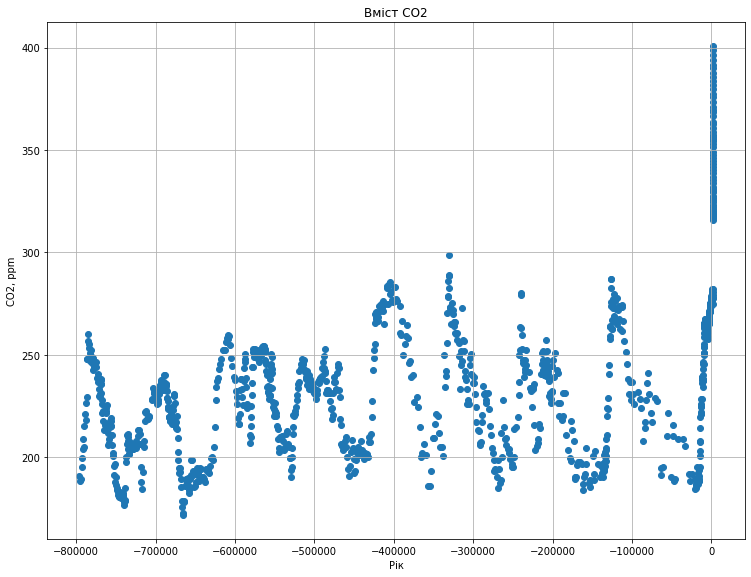

In [3]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(co2_general['Year'], co2_general['quantity_co2'])
plt.title('Вміст CO2')
plt.xlabel('Рік')
plt.ylabel('CO2, ppm')
plt.grid(True)

plt.show()


### Метан (CH4)

In [4]:
ch4 = pd.read_csv('data/randomtree/meth-concentrations.csv', header = 7)

ch4_new = ch4.drop({'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 4', 'Unnamed: 5'}, 1)
ch4_new = ch4_new.dropna()

ch4_new[['Ice Core Measurements']] = ch4_new[['Ice Core Measurements']].apply(pd.to_numeric)
ch4_new = ch4_new.rename({"Unnamed: 3": "quantity_ch4"}, axis = 'columns')

ch4_old = ch4.drop({'Unnamed: 3', 'Unnamed: 2', 'Unnamed: 4', 'Unnamed: 5'}, 1)
ch4_old = ch4_old.dropna()

ch4_old[['Ice Core Measurements']] = ch4_old[['Ice Core Measurements']].apply(pd.to_numeric)
ch4_old = ch4_old.rename({"Unnamed: 1": "quantity_ch4"}, axis = 'columns')

ch4_df = [ch4_old, ch4_new]
ch4_general = pd.concat(ch4_df)

ch4_general = ch4_general.rename({"Ice Core Measurements": "Year"}, axis = 'columns')

ch4_general.head()

,Year,quantity_ch4
0,-797446.1,399.3
1,-796467.4,457.8
2,-795327.0,396.1
3,-794369.7,418.0
4,-792988.0,428.3


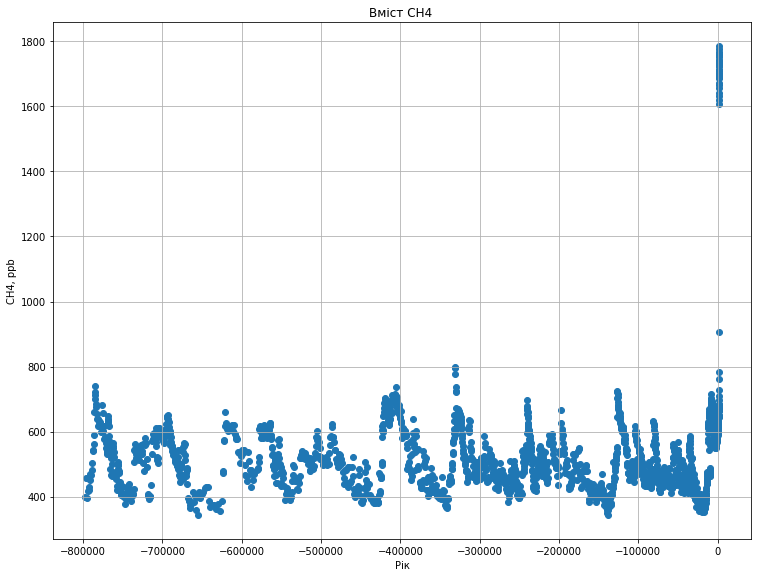

In [5]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(ch4_general['Year'], ch4_general['quantity_ch4'])
plt.title('Вміст CH4 ')
plt.xlabel('Рік')
plt.ylabel('CH4, ppb')
plt.grid(True)

plt.show()


### Оксид азоту (N2O) 

In [6]:
n2o = pd.read_csv('data/randomtree/no2-concentrations.csv', header = 7)

n2o_new = n2o.drop({'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6'}, 1)
n2o_new = n2o_new.dropna()

n2o_new[['Ice Core Measurements']] = n2o_new[['Ice Core Measurements']].apply(pd.to_numeric)
n2o_new = n2o_new.rename({"Unnamed: 4": "quantity_n2o"}, axis = 'columns')

n2o_old = n2o.drop({'Unnamed: 4', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6'}, 1)
n2o_old = n2o_old.dropna()

n2o_old[['Ice Core Measurements']] = n2o_old[['Ice Core Measurements']].apply(pd.to_numeric)
n2o_old = n2o_old.rename({"Unnamed: 1": "quantity_n2o"}, axis = 'columns')

n2o_df = [n2o_old, n2o_new]
n2o_general = pd.concat(n2o_df)

n2o_general = n2o_general.rename({"Ice Core Measurements": "Year"}, axis = 'columns')

n2o_general

,Year,quantity_n2o
0,-796475,254.000000
1,-794430,248.800000
2,-792569,238.700000
3,-790916,238.700000
4,-789474,249.700000
...,...,...
959,2011,323.424167
960,2012,324.380000
961,2013,325.307500
962,2014,326.198333


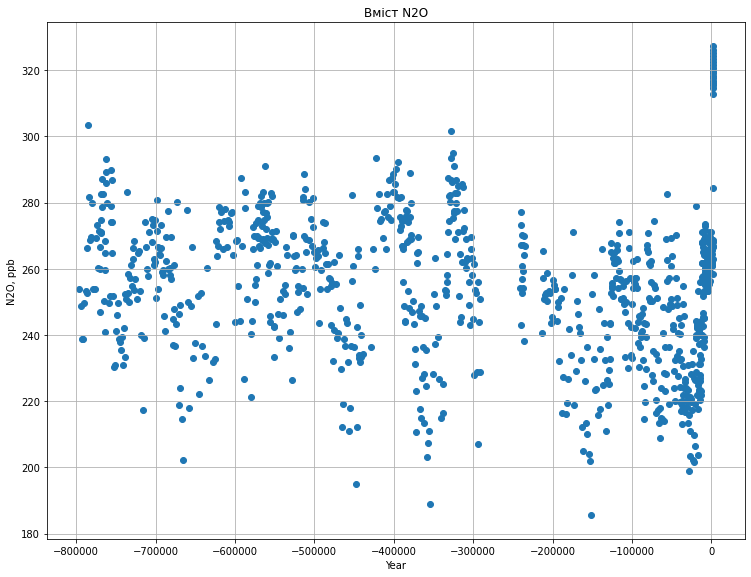

In [7]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(n2o_general['Year'], n2o_general['quantity_n2o'])
plt.title('Вміст N2O')
plt.xlabel('Year')
plt.ylabel('N2O, ppb')
plt.grid(True)

plt.show()

## Лінійна інтерполяція даних

Дані, зібрані за 800 000 років, не відповідають один одному. Наприклад, в 1900 році може бути CO2 і відповідна температура, але в той час може бути відсутнім відповідна концентрація N2O і CH4. Щоб підготувати дані для машинного навчання, необхідно зробити лінійну інтерполяцію для вирівнювання даних, оскільки алгоритми машинного навчання не можуть ефективно обробляти пропущені точки даних.




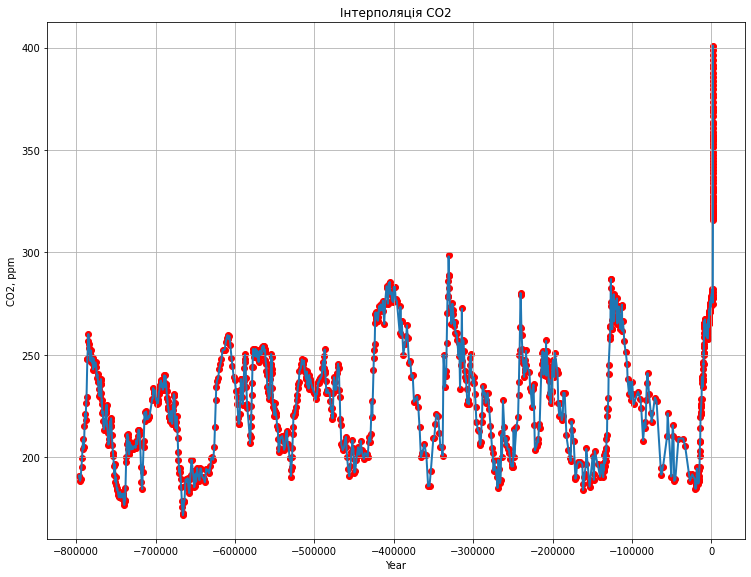

In [8]:
y = np.array(co2_general['quantity_co2'])
x = np.array(co2_general['Year'])

f_co2 = interpolate.interp1d(x, y, kind = 'linear')

xnew = np.linspace(co2_general['Year'].min(), co2_general['Year'].max(), 10000)

fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.title('Інтерполяція CO2')
plt.xlabel('Year')
plt.ylabel('CO2, ppm')
plt.grid(True)


plt.plot(xnew, f_co2(xnew), linewidth=2)
plt.scatter(x, y,  color='red')

plt.show()

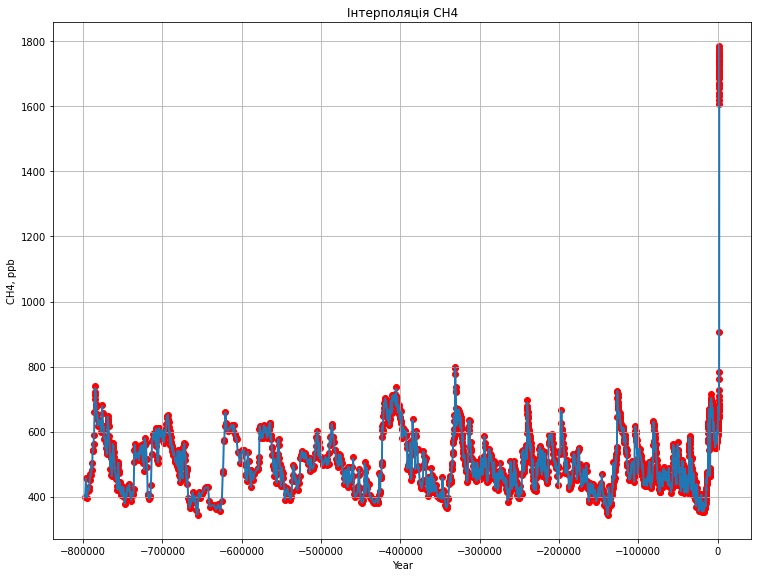

In [9]:
y = np.array(ch4_general['quantity_ch4'])
x = np.array(ch4_general['Year'])

f_ch4 = interpolate.interp1d(x, y, kind = 'linear')

xnew = np.linspace(ch4_general['Year'].min(), ch4_general['Year'].max(), 10000)

fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.title('Інтерполяція CH4')
plt.xlabel('Year')
plt.ylabel('CH4, ppb')
plt.grid(True)


plt.plot(xnew, f_ch4(xnew), linewidth=2)
plt.scatter(x, y,  color='red')

plt.show()

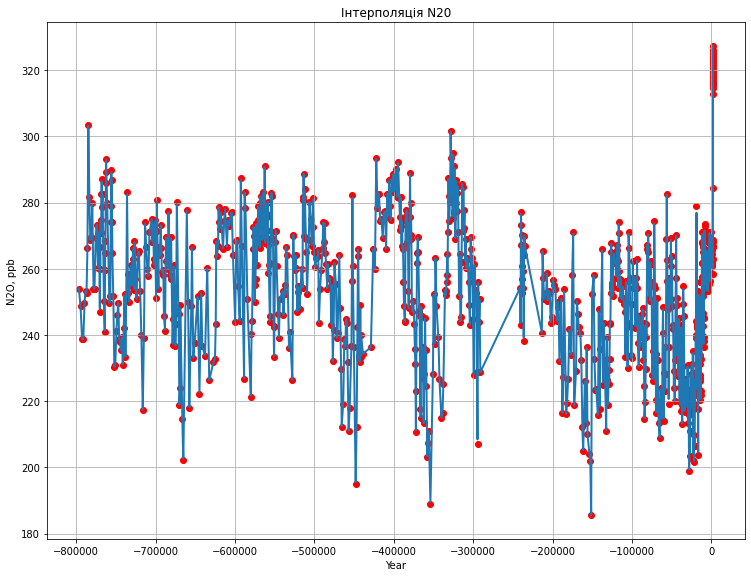

In [10]:
y = np.array(n2o_general['quantity_n2o'])
x = np.array(n2o_general['Year'])

f_n2o = interpolate.interp1d(x, y, kind = 'linear')

xnew = np.linspace(n2o_general['Year'].min(), n2o_general['Year'].max(), 10000)

fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.title('Інтерполяція N20')
plt.xlabel('Year')
plt.ylabel('N2O, ppb')
plt.grid(True)


plt.plot(xnew, f_n2o(xnew), linewidth=2)
plt.scatter(x, y,  color='red')

plt.show()

## Середня температура поверхності землі



In [11]:
global_temp = pd.read_csv('data/GlobalTemperatures.csv')
global_temp_df = global_temp[["dt","LandAverageTemperature"]]
global_temp_df = global_temp_df.dropna()

global_temp_df['dt'] = pd.to_datetime(global_temp_df['dt'], format='%Y-%m-%d', errors='ignore')

global_temp_df['Year'] = global_temp_df['dt'].apply(lambda x: x.year)
del global_temp_df['dt']

global_temp_df = global_temp_df.groupby(['Year']).mean()

global_temp_df = global_temp_df.rename({"LandAverageTemperature": "Temperature"}, axis = 'columns')
global_temp_df['Year'] = global_temp_df.index

global_temp_df['Year'] = pd.to_datetime(global_temp_df['Year'], format='%Y')
global_temp_df['Year'] = global_temp_df['Year'].apply(lambda x: x.year)

global_temp_df.head()

,Temperature,Year
Year,,
1750,8.719364,1750
1751,7.976143,1751
1752,5.779833,1752
1753,8.388083,1753
1754,8.469333,1754


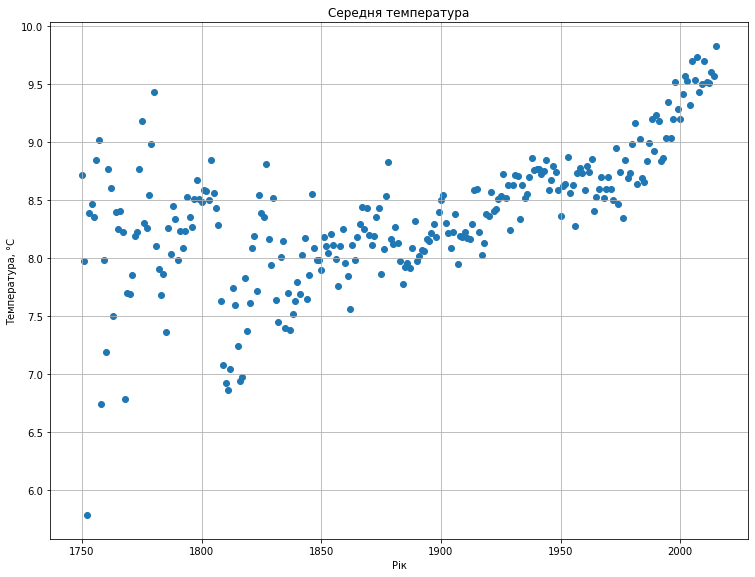

In [12]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(global_temp_df.index, global_temp_df['Temperature'])
plt.title('Середня температура')
plt.xlabel('Рік')
plt.ylabel('Температура, °C')
plt.grid(True)

plt.show()

## Об'єднання даних

In [13]:
co2 = np.array(global_temp_df['Year'].apply(lambda x: f_co2(x)))
ch4 = np.array(global_temp_df['Year'].apply(lambda x: f_ch4(x)))
n2o = np.array(global_temp_df['Year'].apply(lambda x: f_n2o(x)))

d = {'Year': global_temp_df['Year'], 
     'Temperature': global_temp_df['Temperature'],
    'CO2': co2,
    'CH4': ch4,
    'N2O': n2o}


general = pd.DataFrame(data = d)

general.head()

,Year,Temperature,CO2,CH4,N2O
Year,,,,,
1750,1750,8.719364,277.754962,699.322881,268.555263
1751,1751,7.976143,277.796947,701.073016,268.526316
1752,1752,5.779833,277.838931,702.823151,268.497368
1753,1753,8.388083,277.880916,704.573286,268.468421
1754,1754,8.469333,277.922901,706.323421,268.439474


# Аналіз даних

## Аналіз підвищення температури

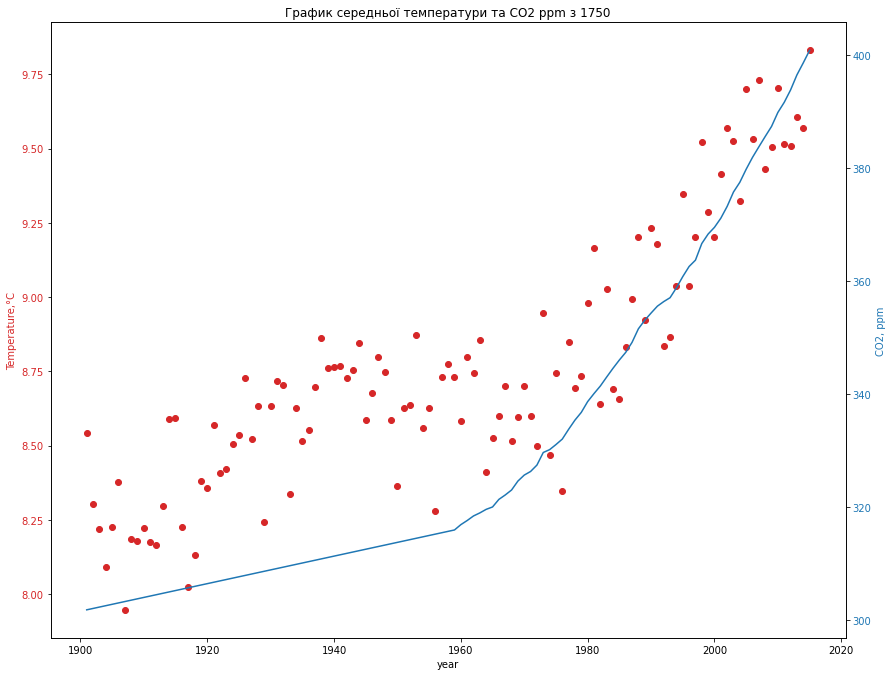

In [14]:
y = global_temp_df[global_temp_df.index > 1900]
# y = np.array(y['Year'])

x1 = np.array(y['Temperature'])
y = np.array(y['Year'])
x2 = f_co2(y)

fig, ax1 = plt.subplots()
fig.set_size_inches(12.5, 9.5)
plt.title('График середньої температури та CO2 ppm з 1750')


color = 'tab:red'
ax1.set_xlabel('year')
ax1.set_ylabel('Temperature,°C', color=color)
ax1.scatter(y, x1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('CO2, ppm', color=color)  # we already handled the x-label with ax1
ax2.plot(y, x2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

На графіку вище зображені дані температури та концентрації СO2 за останні 120 років. Можна побачити тенденцію до підвищення температури за останні кілька десятків років. Крім того, графік концентрація вуглекислого газу також коригує з температурним графіком, тобто, можна припустити, що вони повязані між собою та це може бути присиною потепління Землі.


## Машинне навчання


__Застосування алгоритмів машинного навчання__

Машинне навчання - це набір статистичних методів для аналізу тенденцій, пошук взаємозв'язку та розробка моделей для прогнозування на основі баз даних. 
В данній роботі досліджено наступні алгоритми:
- Лінійна регресія
- Випадковий ліс (Random Forest)
- Метод опорних векторів (SVR)


Розділимо дані випадковим чином на дві парні вибірки: для навчання та тестування.

In [15]:
sc_x = StandardScaler()
sc_y = StandardScaler()

X = general.iloc[:, 2:5]
y = general.iloc[:, 1].values.reshape(-1, 1)

X = sc_x.fit_transform(X)
y = sc_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

In [16]:
X_co2 = general[['CO2']].values.reshape(-1, 1)
y_co2 = general['Temperature'].values.reshape(-1, 1)

# sc_x_co2 = StandardScaler()
sc_y_co2 = StandardScaler()

# X_co2 = sc_x_co2.fit_transform(X_co2)
y_co2 = sc_y.fit_transform(y_co2)

X_co2_train, X_co2_test, y_co2_train, y_co2_test = train_test_split(X_co2, y_co2, test_size = 0.2, random_state = 25)
# X_co2_train = X_co2_train.reshape(-1, 1)
# X_co2_test = X_co2_test.reshape(-1, 1)

In [17]:
X_ch4 = general[['CH4']].values.reshape(-1, 1)
y_ch4 = general['Temperature'].values.reshape(-1, 1)

# sc_x_ch4 = StandardScaler()
sc_y_ch4 = StandardScaler()

# X_ch4 = sc_x_ch4.fit_transform(X_ch4)
y_ch4 = sc_y_ch4.fit_transform(y_ch4)


X_ch4_train, X_ch4_test, y_ch4_train, y_ch4_test = train_test_split(X_ch4, y_ch4, test_size = 0.2, random_state = 10)

# X_ch4_train = X_co2_train.reshape(-1, 1)
# X_ch4_test = X_co2_test.reshape(-1, 1)

In [18]:
X_n2o = general[['N2O']].values.reshape(-1, 1)
y_n2o = general['Temperature'].values.reshape(-1, 1)


# sc_x_n2o = StandardScaler()
sc_y_n2o = StandardScaler()

# X_ch4 = sc_x_ch4.fit_transform(X_ch4)
y_n2o = sc_y_n2o.fit_transform(y_n2o)


X_n2o_train, X_n2o_test, y_n2o_train, y_n2o_test = train_test_split(X_n2o, y_n2o, test_size = 0.2, random_state = 25)

# X_ch4_train = X_co2_train.reshape(-1, 1)
# X_ch4_test = X_co2_test.reshape(-1, 1)


### Лінійна регресія

#### СО2

In [19]:
LinearRefModel_co2 = LinearRegression()
LinearRefModel_co2.fit(X_co2_train, np.ravel(y_co2_train))

y_co2_pred = LinearRefModel_co2.predict(X_co2_test)
mse = mean_squared_error(y_co2_test, y_co2_pred)
rmse_linear_co2 = np.sqrt(mse)
rmse_linear_co2

0.6948185912991607

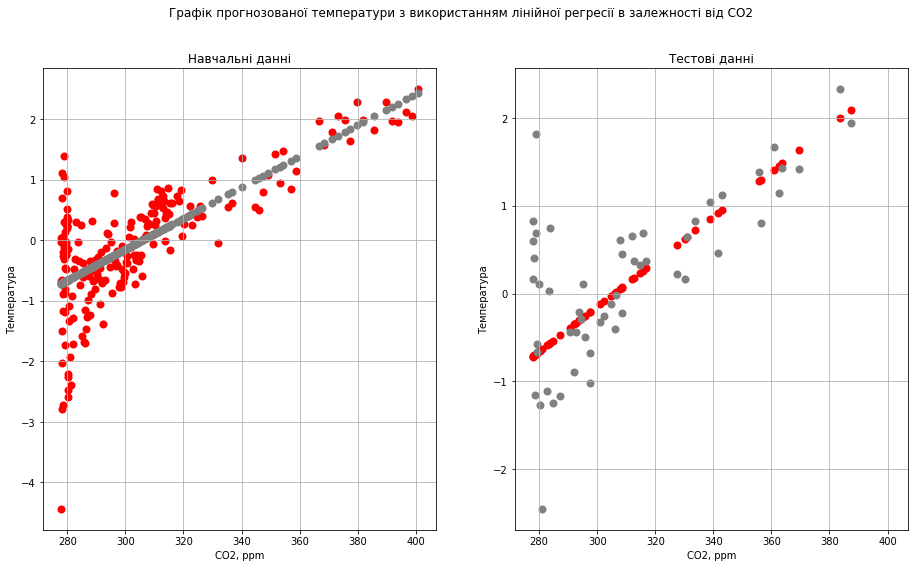

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_co2_train, y_co2_train, color='red', linewidth=2)
ax.scatter(X_co2_train, LinearRefModel_co2.predict(X_co2_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_co2_test, y_co2_pred, color='red', linewidth=2)
ax.scatter(X_co2_test, y_co2_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням лінійної регресії в залежності від CO2')

plt.show()

#### CH4

In [21]:
LinearRefModel_ch4 = LinearRegression()
LinearRefModel_ch4.fit(X_ch4_train, np.ravel(y_ch4_train))

y_ch4_pred = LinearRefModel_ch4.predict(X_ch4_test)
mse = mean_squared_error(y_ch4_test, y_ch4_pred)
rmse_linear_ch4 = np.sqrt(mse)
rmse_linear_ch4

0.749415084029308

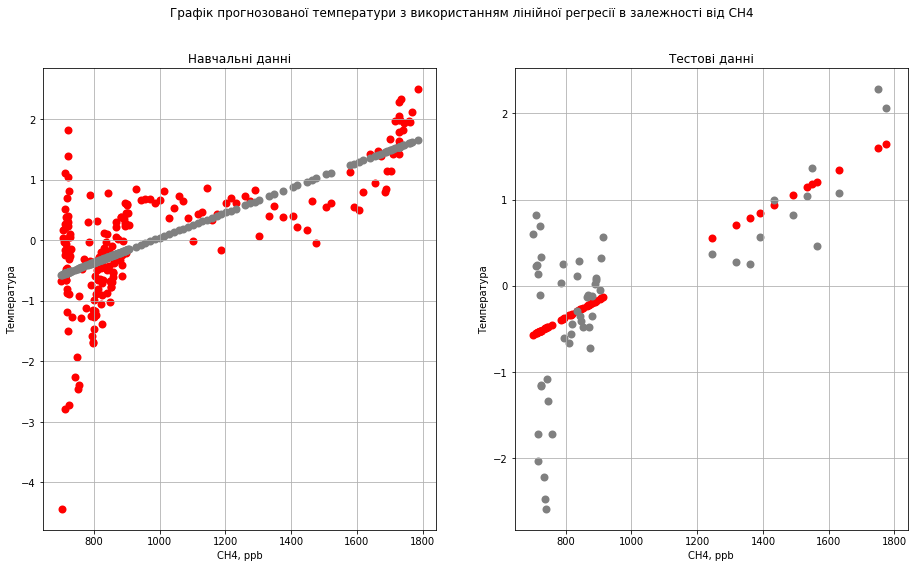

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_ch4_train, y_ch4_train, color='red', linewidth=2)
ax.scatter(X_ch4_train, LinearRefModel_ch4.predict(X_ch4_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_ch4_test, y_ch4_pred, color='red', linewidth=2)
ax.scatter(X_ch4_test, y_ch4_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням лінійної регресії в залежності від CH4')

plt.show()

#### N20

In [23]:
LinearRefModel_n2o = LinearRegression()
LinearRefModel_n2o.fit(X_n2o_train, np.ravel(y_n2o_train))

y_n2o_pred = LinearRefModel_n2o.predict(X_n2o_test)
mse = mean_squared_error(y_n2o_test, y_n2o_pred)
rmse_linear_n2o = np.sqrt(mse)
rmse_linear_n2o

0.6880545543399419

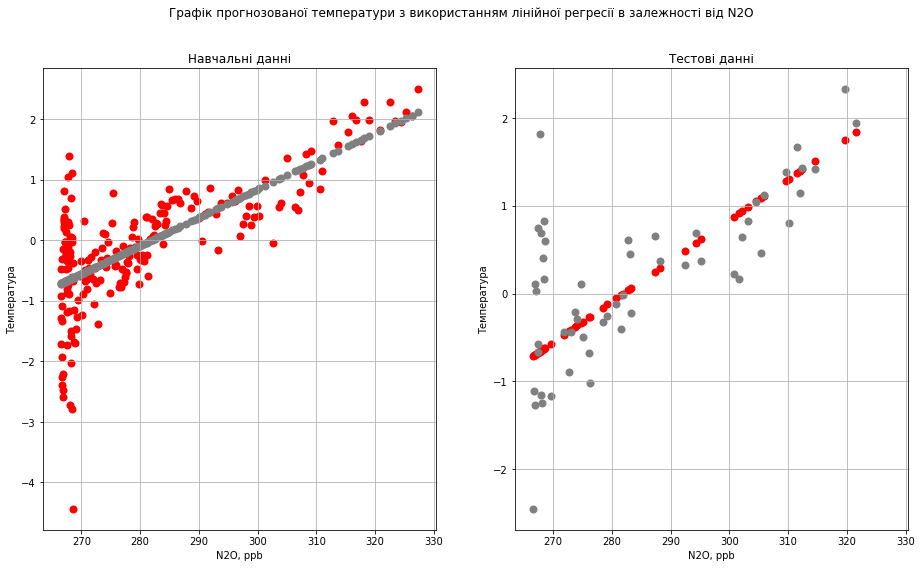

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_n2o_train, y_n2o_train, color='red', linewidth=2)
ax.scatter(X_n2o_train, LinearRefModel_n2o.predict(X_n2o_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_n2o_test, y_n2o_pred, color='red', linewidth=2)
ax.scatter(X_n2o_test, y_n2o_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням лінійної регресії в залежності від N2O')

plt.show()

#### Багатофакторна модель

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

LinearRefModel = LinearRegression()
LinearRefModel.fit(X_train, y_train)
y_pred = LinearRefModel.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse)
rmse_linear

0.6837654404461568

In [27]:
LinearModel_error = {'CO2': rmse_linear_co2, 'CH4': rmse_linear_ch4, 'N2O': rmse_linear_n2o, 'Multiple': rmse_linear}

### Random Forest


#### СО2

In [28]:
RandomForestRefModel_co2 = RandomForestRegressor()
RandomForestRefModel_co2.fit(X_co2_train, np.ravel(y_co2_train))

RandomForestRegressor()

In [29]:
y_co2_pred = RandomForestRefModel_co2.predict(X_co2_test)
mse = mean_squared_error(y_co2_test, y_co2_pred)
rmse_forest_co2 = np.sqrt(mse)
rmse_forest_co2

0.5460400487087332

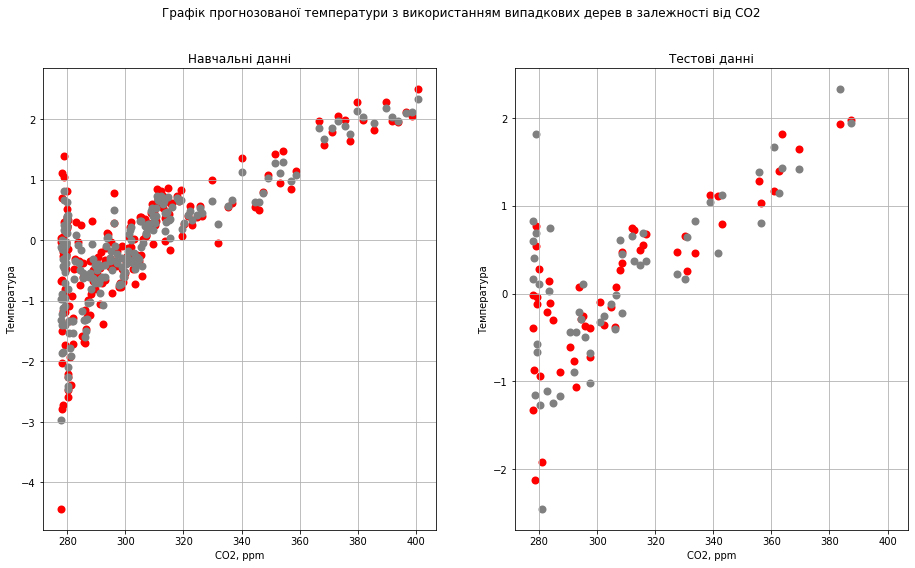

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_co2_train, y_co2_train, color='red', linewidth=2)
ax.scatter(X_co2_train, RandomForestRefModel_co2.predict(X_co2_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_co2_test, y_co2_pred, color='red', linewidth=2)
ax.scatter(X_co2_test, y_co2_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням випадкових дерев в залежності від CO2')

plt.show()

#### CH4

In [31]:
RandomForestRefModel_ch4 = RandomForestRegressor()
RandomForestRefModel_ch4.fit(X_ch4_train, np.ravel(y_ch4_train))

RandomForestRegressor()

In [32]:
y_ch4_pred = RandomForestRefModel_ch4.predict(X_ch4_test)
mse = mean_squared_error(y_ch4_test, y_ch4_pred)
rmse_forest_ch4 = np.sqrt(mse)
rmse_forest_ch4

0.6767222444072878

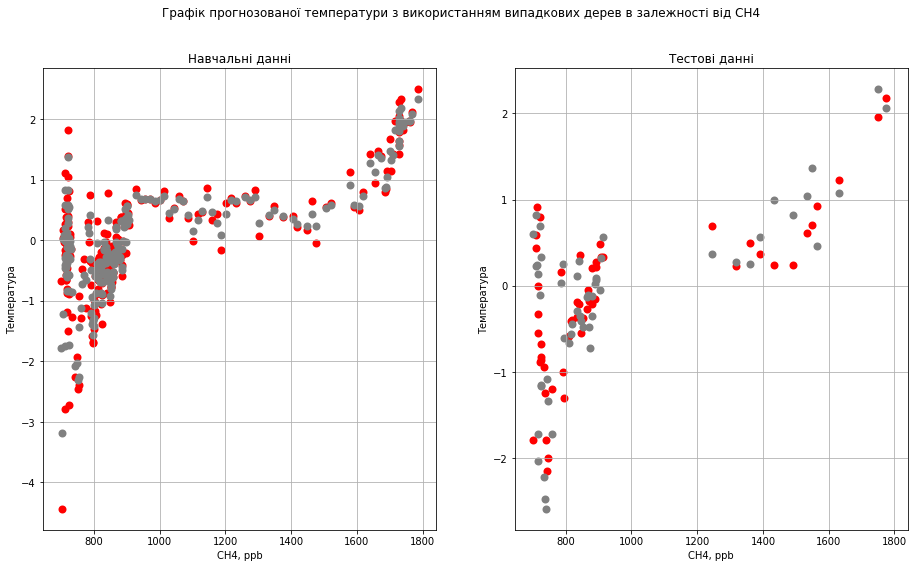

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_ch4_train, y_ch4_train, color='red', linewidth=2)
ax.scatter(X_ch4_train, RandomForestRefModel_ch4.predict(X_ch4_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_ch4_test, y_ch4_pred, color='red', linewidth=2)
ax.scatter(X_ch4_test, y_ch4_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням випадкових дерев в залежності від CH4')

plt.show()

#### N20

In [34]:
RandomForestRefModel_n2o = RandomForestRegressor()
RandomForestRefModel_n2o.fit(X_n2o_train, np.ravel(y_n2o_train))

RandomForestRegressor()

In [35]:
y_n2o_pred = RandomForestRefModel_n2o.predict(X_n2o_test)
mse = mean_squared_error(y_n2o_test, y_n2o_pred)
rmse_forest_n2o = np.sqrt(mse)
rmse_forest_n2o

0.6462019558337565

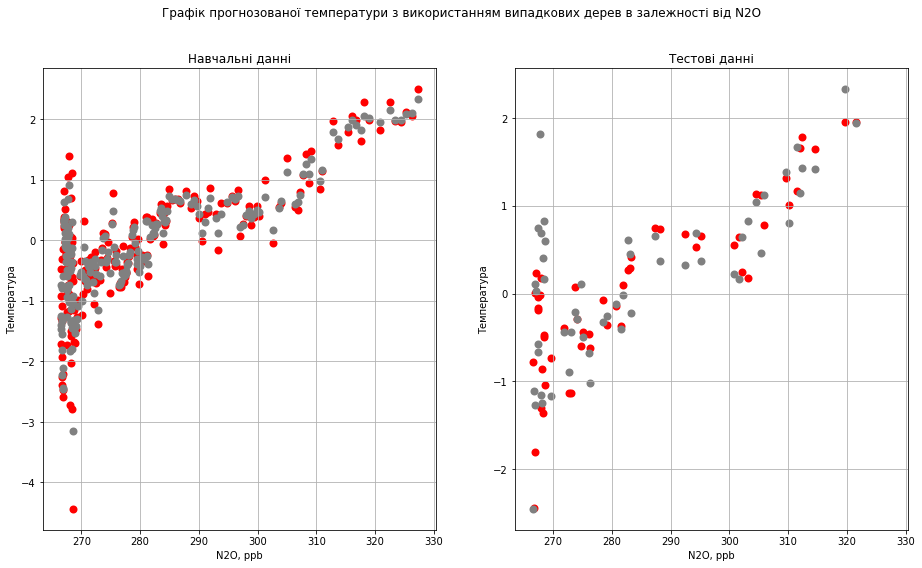

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_n2o_train, y_n2o_train, color='red', linewidth=2)
ax.scatter(X_n2o_train, RandomForestRefModel_n2o.predict(X_n2o_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_n2o_test, y_n2o_pred, color='red', linewidth=2)
ax.scatter(X_n2o_test, y_n2o_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням випадкових дерев в залежності від N2O')

plt.show()

#### Багатофакторна

In [37]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, np.ravel(y_train))
y_pred = regressor.predict(X_test)

In [38]:
mse = mean_squared_error(y_test, y_pred)
rmse_forest = np.sqrt(mse)
rmse_forest

0.5269994516746133

In [39]:
RandomForest_error = {'CO2': rmse_forest_co2, 'CH4': rmse_forest_ch4, 'N2O': rmse_forest_n2o, 'Multiple': rmse_forest}

### SVR

Регрессия опорных векторов - это тип машины опорных векторов, которая поддерживает линейную и нелинейную регрессию. Как видно на графике ниже, миссия состоит в том, чтобы разместить как можно больше экземпляров между линиями, одновременно ограничивая нарушения границ. Концепция нарушения в этом примере представлена ​​как ε (эпсилон).

#### СО2

In [40]:
SVRRegModel_co2 = SVR(kernel='rbf')
SVRRegModel_co2.fit(X_co2_train, np.ravel(y_co2_train))

SVR()

In [41]:
y_co2_pred = SVRRegModel_co2.predict(X_co2_test)
mse = mean_squared_error(y_co2_test, y_co2_pred)
rmse_svr_co2 = np.sqrt(mse)
rmse_svr_co2

0.6193437226148238

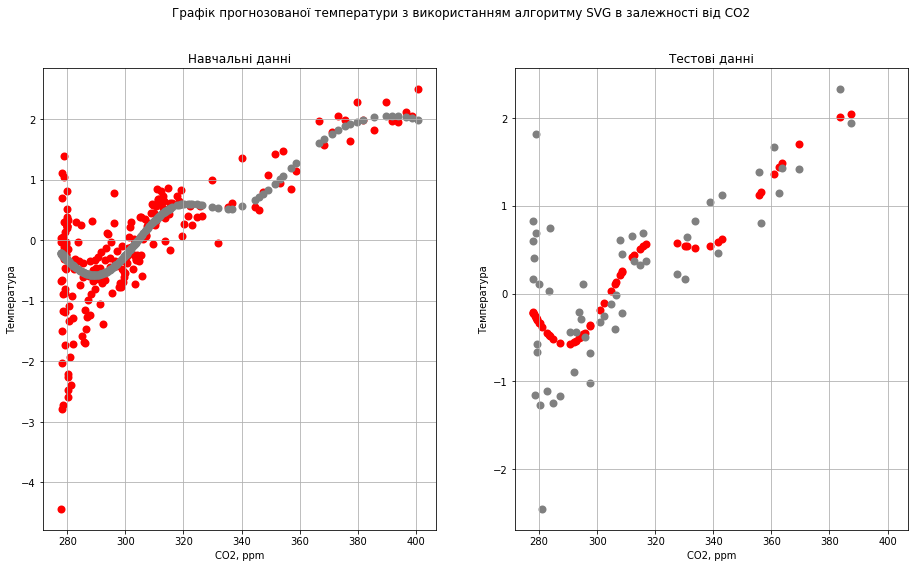

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_co2_train, y_co2_train, color='red', linewidth=2)
ax.scatter(X_co2_train, SVRRegModel_co2.predict(X_co2_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_co2_test, y_co2_pred, color='red', linewidth=2)
ax.scatter(X_co2_test, y_co2_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('СO2, ppm')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням алгоритму SVG в залежності від CO2')

plt.show()

#### CH4

In [43]:
SVRRegModel_ch4 = SVR(kernel='rbf')
SVRRegModel_ch4.fit(X_ch4_train, np.ravel(y_ch4_train))

SVR()

In [44]:
y_ch4_pred = SVRRegModel_ch4.predict(X_ch4_test)
mse = mean_squared_error(y_ch4_test, y_ch4_pred)
rmse_svr_ch4 = np.sqrt(mse)
rmse

NameError: name 'rmse' is not defined

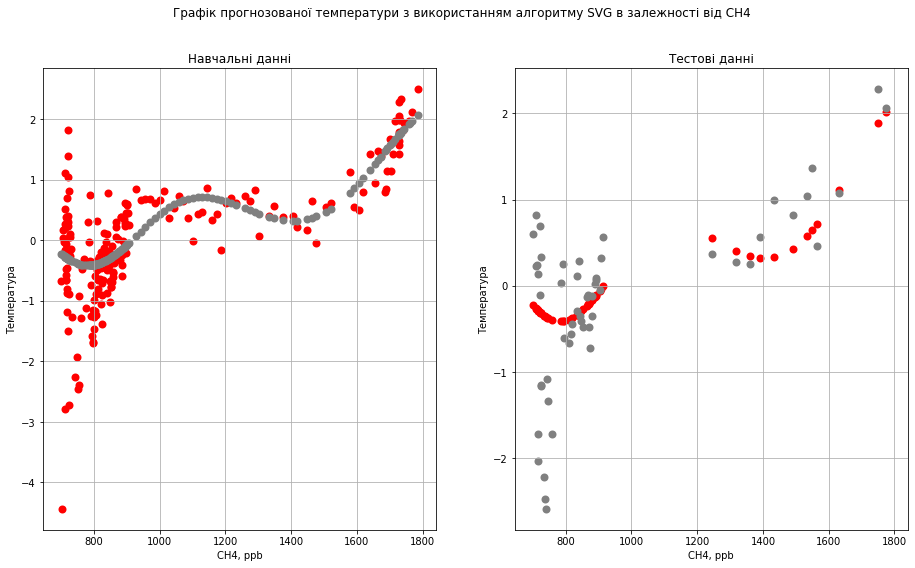

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_ch4_train, y_ch4_train, color='red', linewidth=2)
ax.scatter(X_ch4_train, SVRRegModel_ch4.predict(X_ch4_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_ch4_test, y_ch4_pred, color='red', linewidth=2)
ax.scatter(X_ch4_test, y_ch4_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('CH4, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням алгоритму SVG в залежності від CH4')

plt.show()

#### N2O

In [46]:
SVRRegModel_n2o = SVR(kernel='rbf')
SVRRegModel_n2o.fit(X_n2o_train, np.ravel(y_n2o_train))

SVR()

In [47]:
y_n2o_pred = SVRRegModel_n2o.predict(X_n2o_test)
mse = mean_squared_error(y_n2o_test, y_n2o_pred)
rmse_svr_n2o = np.sqrt(mse)
rmse_svr_n2o

0.6457835259342717

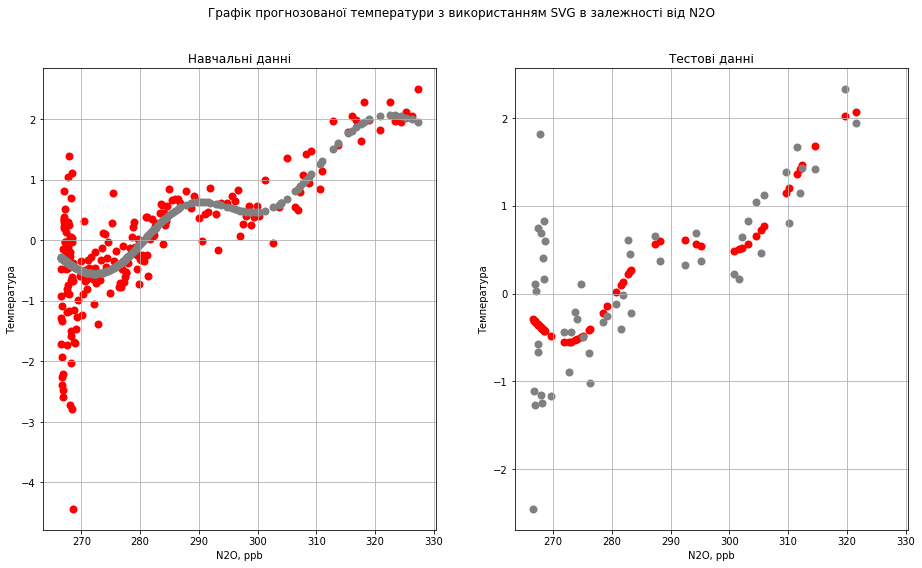

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(15.5, 8.5)

ax = axs[0]
ax.scatter(X_n2o_train, y_n2o_train, color='red', linewidth=2)
ax.scatter(X_n2o_train, SVRRegModel_n2o.predict(X_n2o_train), color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Навчальні данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)

ax = axs[1]
ax.scatter(X_n2o_test, y_n2o_pred, color='red', linewidth=2)
ax.scatter(X_n2o_test, y_n2o_test, color='grey', linewidth=2)
ax.grid(True)
ax.set_title('Тестові данні')
ax.set_xlabel('N2O, ppb')
ax.set_ylabel('Температура')
ax.grid(True)


fig.suptitle('Графік прогнозованої температури з використанням SVG в залежності від N2O')

plt.show()

#### Багатофакторна

In [49]:
SVRRegModel = SVR(kernel='rbf')
SVRRegModel.fit(X_train,np.ravel(y_train))

y_pred = SVRRegModel.predict(X_test)

In [50]:
mse = mean_squared_error(y_test, y_pred)
rmse_svr = np.sqrt(mse)
rmse_svr

0.6178453928848522

In [51]:
svrModel_error = {'CO2': rmse_svr_co2, 'CH4': rmse_svr_ch4, 'N2O': rmse_svr_n2o, 'Multiple': rmse_svr}

# Порівняння оцінок моделей

Отримані прогнози були оцінені порівняно зі значеннями в наборах даних. 
Оцінка моделей відбувається за допомогою середньоквадратичної помилки.Середняквадратична помилка вимірює середнє значення квадратів помилок між нашими модельними предсказаниями та реальними данними та підходить для задач регресії. 

In [52]:
print("Linear Reggresion:", LinearModel_error)
print("Random Forest:", RandomForest_error)
print("SVR:", svrModel_error)

Linear Reggresion: {'CO2': 0.6948185912991607, 'CH4': 0.749415084029308, 'N2O': 0.6880545543399419, 'Multiple': 0.6837654404461568}
Random Forest: {'CO2': 0.5460400487087332, 'CH4': 0.6767222444072878, 'N2O': 0.6462019558337565, 'Multiple': 0.5269994516746133}
SVR: {'CO2': 0.6193437226148238, 'CH4': 0.7531694359496465, 'N2O': 0.6457835259342717, 'Multiple': 0.6178453928848522}


Результати навчання та тестування середньої квадратичної помилки наведені в таблиці нижче. 

__Порівняльна таблиця середньої помилки в квадраті залежно від методу__

| Модель | СО2 | CH4 | N2O | Багатофакторна |
|------|------|------|------|------|
|   Лінійна регресія  | 0.695 | 0.794 | 0.688 | 0.684 |
|  Random forest   | 0.570 | 0.645 | 0.625 | 0.527 |
|  SVG   | 0.612 | 0.753 | 0.646 | 0.618 |


За показником видно, що найточнішу модель дає випадковий ліс. За графіками також видно, що ця модель більш точно описує зміну температури залежно від концентрації парникових газів. 

Оскільки випадковий ліс ефективно працює з даним набором даних та може ефективно оцінювати невистачаючі дані, на основі цієї моделі можна побудувати більш точну модель прогнозування температури з більшим набором факторів.

Також точність алгоритму дозволяє отримати діаграму важливостей різних факторів у функції:

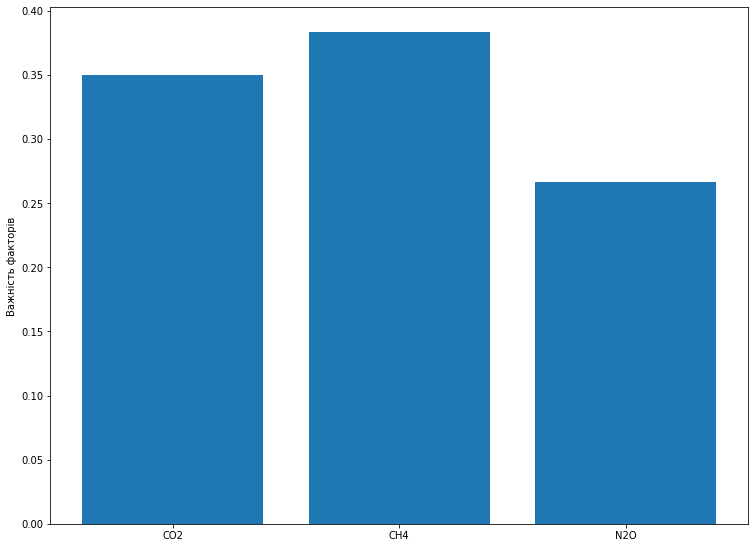

In [53]:
imp = regressor.feature_importances_
x = np.arange(3)

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 9.5)
ax.set_ylabel('Важність факторів')

# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, imp)
plt.xticks(x, ('CO2', 'CH4', 'N2O'))
plt.show()

# Прородні данні

## Сонячна радіація

In [54]:
solar = pd.read_csv('data/tsi.csv', sep=';', names = ['dt', 'sunspot_darkening_function', 'facular_brightening_function', 'source'], header = 1)

solar['dt'] = pd.to_datetime(solar['dt'], format='%Y-%m-%d', errors='ignore')

solar['Year'] = solar['dt'].apply(lambda x: x.year)
del solar['dt']

solar = solar.groupby(['Year']).mean()
solar['tsi'] = solar['facular_brightening_function']
solar = solar.drop({'sunspot_darkening_function', 'facular_brightening_function'}, 1)
solar = solar.dropna()

solar = solar.loc[solar.index < 2016]

solar.head()

,tsi
Year,
1882,0.153726
1883,0.154528
1884,0.155206
1885,0.153463
1886,0.150510


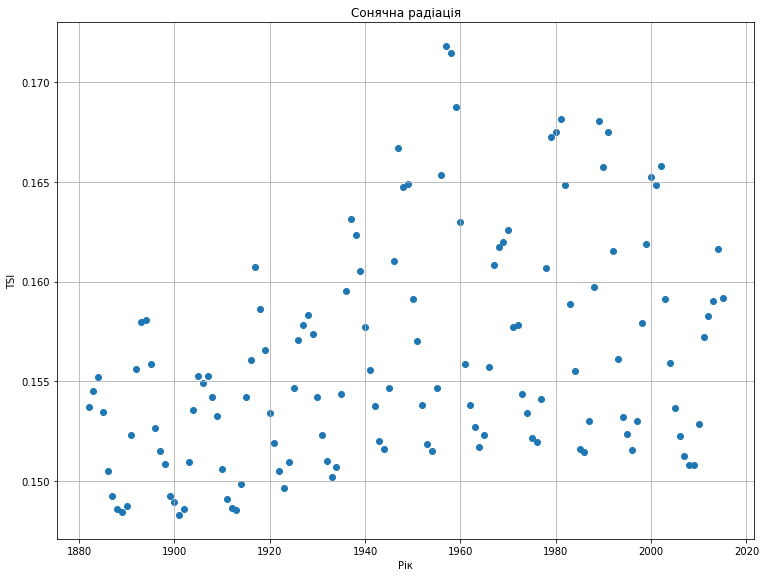

In [55]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(solar.index, solar['tsi'])


plt.title('Сонячна радіація')
plt.xlabel('Рік')
plt.ylabel('TSI')
plt.grid(True)

plt.show()

## Вулканічна діяльність

In [56]:
vei = pd.read_csv('data/vei.csv', header=1, names=['Year', 'VEI'])
vei.head()
vei = vei.dropna()

vei = vei.loc[vei['Year'] > 1800]

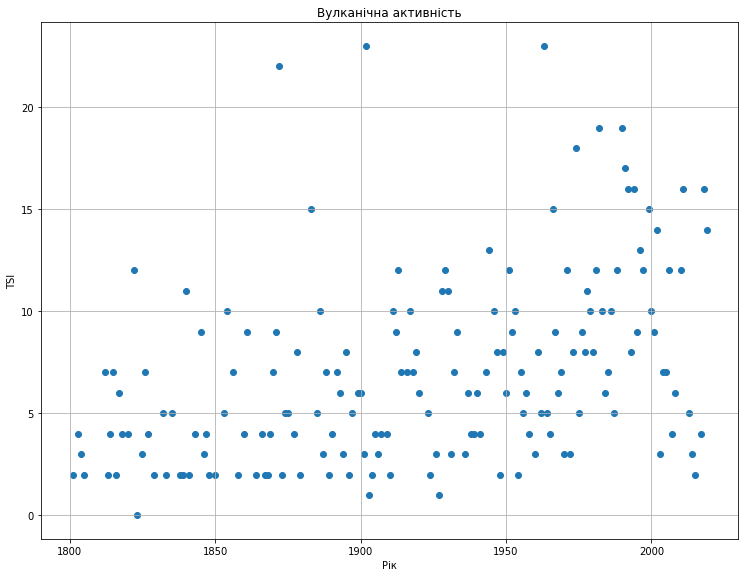

In [57]:
fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.scatter(vei['Year'], vei['VEI'])


plt.title('Вулканічна активність')
plt.xlabel('Рік')
plt.ylabel('TSI')
plt.grid(True)

plt.show()

#### Лінійна інтерполяція

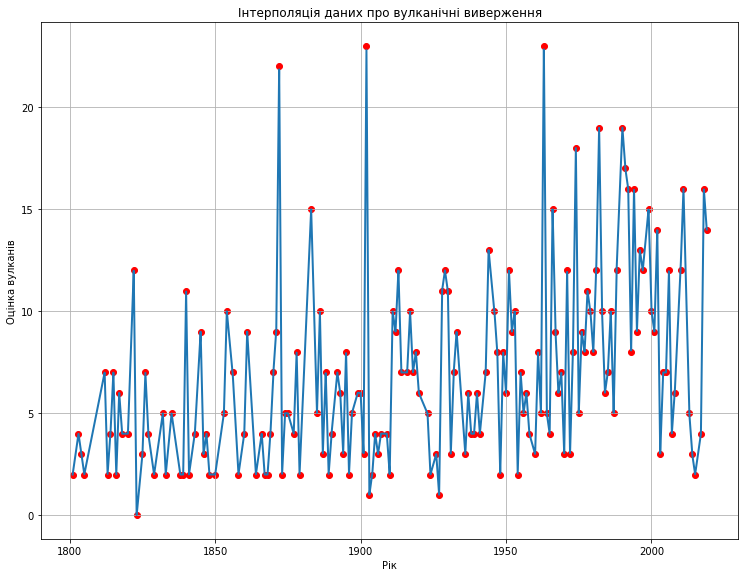

In [58]:
y = np.array(vei['VEI'])
x = np.array(vei['Year'])

f_vie = interpolate.interp1d(x, y, kind = 'linear')

xnew = np.linspace(vei['Year'].min(), vei['Year'].max(), 10000)

fig = plt.figure()
fig.set_size_inches(12.5, 9.5)

plt.title('Інтерполяція даних про вулканічні виверження')
plt.xlabel('Рік')
plt.ylabel('Оцінка вулканів')
plt.grid(True)


plt.plot(xnew, f_vie(xnew), linewidth=2)
plt.scatter(x, y,  color='red')

plt.show()

## Створення загального датасету з природними данними

Обираємо данні, починаючи з максимально доступного року серед всіх датасетів

In [59]:
max_year = solar.index.min()

In [60]:
global_temp_df.head()

,Temperature,Year
Year,,
1750,8.719364,1750
1751,7.976143,1751
1752,5.779833,1752
1753,8.388083,1753
1754,8.469333,1754


In [61]:
temperature = global_temp_df.loc[global_temp_df['Year'] >= max_year]

co2 = np.array(temperature['Year'].apply(lambda x: f_co2(x)))
ch4 = np.array(temperature['Year'].apply(lambda x: f_ch4(x)))
n2o = np.array(temperature['Year'].apply(lambda x: f_n2o(x)))
vei = np.array(temperature['Year'].apply(lambda x: f_vie(x)))
tsi = np.array(solar['tsi'])

data = {'Year': temperature['Year'], 
     'Temperature': temperature['Temperature'],
    'CO2': co2,
    'CH4': ch4,
    'N2O': n2o,
    'VEI': vei,
    'TSI': tsi}

main_df = pd.DataFrame(data = data)
del main_df['Year']
main_df.head()

,Temperature,CO2,CH4,N2O,VEI,TSI
Year,,,,,,
1882,8.128917,297.210479,847.426198,275.965517,11.75,0.153726
1883,7.976917,297.454110,848.517293,276.120690,15.00,0.154528
1884,7.773667,297.697740,849.608388,276.275862,10.00,0.155206
1885,7.919667,297.941370,850.699484,276.431034,5.00,0.153463
1886,7.954500,298.185000,851.790579,276.586207,10.00,0.150510


## Побудова моделей

1. Нормалізація данних
2. Розділення на  навчальну та тестову вибірки

In [62]:
sc_X = StandardScaler()
sc_Y = StandardScaler()

X = main_df.iloc[:, 1:6].values
y = main_df.iloc[:, 0].values.reshape(-1, 1)

X = sc_X.fit_transform(X)
y = sc_Y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

#### Лінійна регресія

In [63]:
LinearRefModel = LinearRegression()
LinearRefModel.fit(X_train, y_train)
y_pred = LinearRefModel.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
rmse_test= np.sqrt(mse_test)
rmse_test

0.34112060554025764

In [64]:
mse_train = mean_squared_error(y_train, LinearRefModel.predict(X_train))
rmse_train = np.sqrt(mse_train)
rmse_train

0.404543124080768

In [65]:
LinearRefModel.coef_

array([[ 0.36864476, -1.20291438,  1.69860038,  0.03124911,  0.02419865]])

In [66]:
LinearRefModel.intercept_

array([-0.00466366])

#### Random Forest

In [67]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, np.ravel(y_train))
y_pred = regressor.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
rmse_test

0.27687381781210313

In [68]:
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
rmse_train

0.1536413693377276

In [69]:
regressor.feature_importances_

array([0.28592776, 0.36803826, 0.28478488, 0.02512725, 0.03612185])

#### SVR

In [70]:
SVRRegModel = SVR(kernel='rbf')
SVRRegModel.fit(X_train,np.ravel(y_train))

y_pred = SVRRegModel.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
rmse_svr = np.sqrt(mse_test)
rmse_svr

0.3381550934549452

In [71]:
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
rmse_train

0.1536413693377276

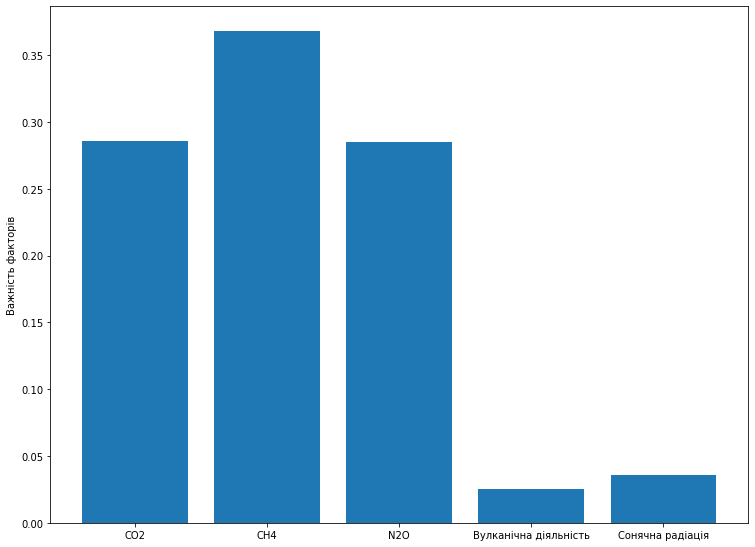

In [72]:
imp = regressor.feature_importances_
x = np.arange(5)

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 9.5)
ax.set_ylabel('Важність факторів')

# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, imp)
plt.xticks(x, ('CO2', 'CH4', 'N2O', 'Вулканічна діяльність', 'Сонячна радіація'))
plt.show()

## Висновок
Найкращим алгоритмом машинного навчання для представлених у даній роботі кліматичних даних є метод Random Forest. Квадрат середньоквадратичної помилки даного алгоритму на тестових даних складає 0.227.
За допомогою моделі, побудованої на основі Random Forest, було оцінено показники важливостей факторів впливу. У досліджені було показано, що метан домінує серед інших парникових газів у впливі н показник середньої температури поверхні землі. Проте два інших парникових гази також мають високий вплив, на відміну від природних факторів впливу.